In [1]:
import src.TrainSetGen as trainingSG
import src.TestingSetGen as testingSG

[train_label, train_coords_A, train_coords_B] = trainingSG.getPoints()
[test_label, test_coords_A, test_coords_B] = testingSG.getPoints()

In [2]:
import src.Common as cm

[train_w, train_doppler] = cm.getWAndDoppler(train_coords_A, train_coords_B)
[test_w, test_doppler] = cm.getWAndDoppler(test_coords_A, test_coords_B)

In [3]:
import numpy as np
import src.Config as cf

vertex1 = np.array([0, 0])
vertex2 = np.array([200, 0])
vertex3 = np.array([100, 100])
vertex4 = np.array([300, 150])

vertices_position = np.concatenate((vertex1, vertex2, vertex3, vertex4))
        
train_position = np.full((cf.train_points_num, len(vertices_position)), vertices_position)
test_position = np.full((cf.test_points_num, len(vertices_position)), vertices_position)


In [4]:
# import torch.nn as nn

# def pointInTriangle(pt, v1, v2, v3):
#     # Barycentric coordinates method
#     def sign(p1, p2, p3):
#         return (p1[0] - p3[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p3[1])

#     b1 = sign(pt, v1, v2) < 0.0
#     b2 = sign(pt, v2, v3) < 0.0
#     b3 = sign(pt, v3, v1) < 0.0

#     return ((b1 == b2) and (b2 == b3))

# def triangleConstraintLoss(outputs, targets, v1, v2, v3):
#     criterion = nn.MSELoss()
    
#     # 计算常规损失
#     mse_loss = criterion(outputs, targets)
    
#     # 计算三角形约束损失
#     constraint_loss = 0.0
#     for output in outputs:
#         # 如果点不在三角形内，增加损失
#         if not pointInTriangle(output, v1, v2, v3):
#             constraint_loss += 100.0

#     # 总损失是常规损失和约束损失的和
#     total_loss = mse_loss + constraint_loss
#     return total_loss

# def triangleConstraintLoss(outputs, targets, v1, v2, v3):
#     criterion = nn.MSELoss()
    
#     print(outputs.shape)
    
#     # 计算常规损失
#     mse_loss = criterion(outputs, targets)
    
#     # # 计算三角形约束损失
#     # constraint_loss = 0.0
#     # for output in outputs:
#     #     # 如果点不在三角形内，增加损失
#     #     if not pointInTriangle(output, v1, v2, v3):
#     #         constraint_loss += 100.0

#     # # 总损失是常规损失和约束损失的和
#     # total_loss = mse_loss + constraint_loss

#     d11 = outputs[0]
#     abs()
#     return total_loss


In [5]:
train_inputs = np.concatenate((train_w, train_doppler, train_position), axis=1)  # 将 相位差和多普勒 拼接
test_inputs = np.concatenate((test_w, test_doppler, test_position), axis=1)  # 将 相位差和多普勒 拼接

def normalize_first_n_columns(data, n):
   # 计算前n列的最大值和最小值
   min_vals = data[:, :n].min(axis=0)
   max_vals = data[:, :n].max(axis=0)

   # 归一化前n列
   data[:, :n] = (data[:, :n] - min_vals) / (max_vals - min_vals)


# normalize the first 6 columns
# normalize_first_n_columns(train_inputs, 6)
# normalize_first_n_columns(test_inputs, 6)

# import numpy as np
# train_other_inputs.fill(0)
# test_other_inputs.fill(0)

In [6]:
import os
import time

current_time = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
result_folder = "results/" + current_time
os.makedirs(result_folder)

training_results_folder = result_folder + "/training"
os.makedirs(training_results_folder)

testing_results_folder= result_folder + "/testing"
os.makedirs(testing_results_folder)


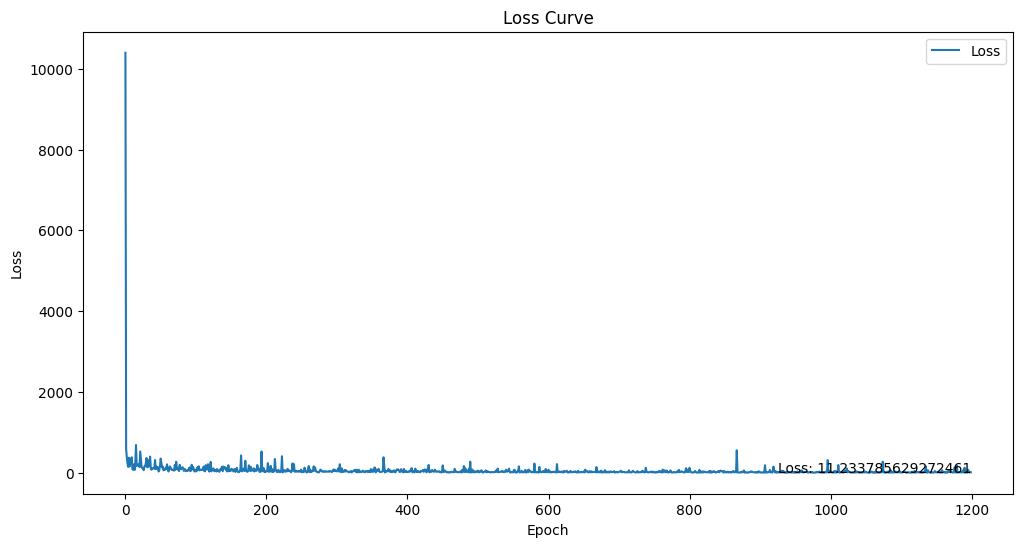

Epoch [1200/1200], Loss: 11.233785629272461


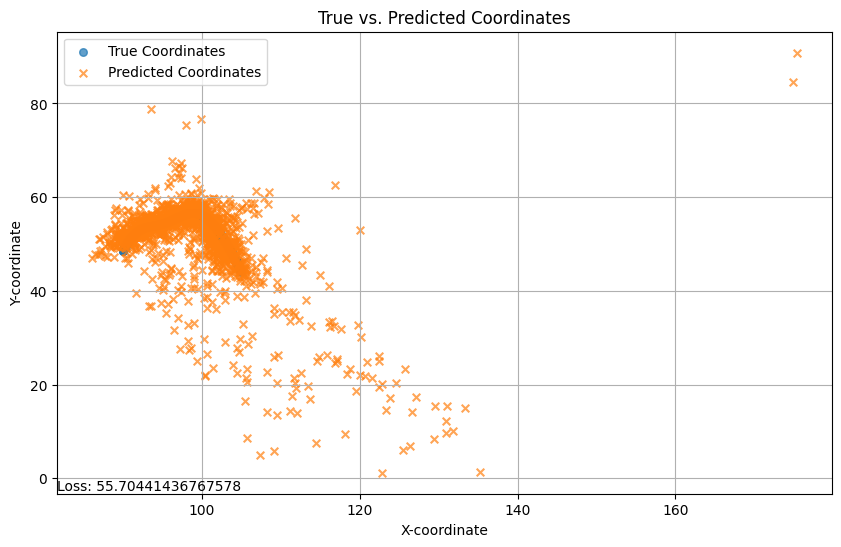

Test Loss: 55.70441436767578


In [7]:
# 定义更深的神经网络模型
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from IPython.display import clear_output

import src.Config as cf
import src.CoordDataset as CoordDataset

if(cf.using_model=="dnn"):
    import src.DnnModel as DnnModel
    using_model = DnnModel.DNN()
elif(cf.using_model=="rbf"):
    import src.RbfModel as RbfModel
    using_model = RbfModel.RBFNetwork()
else:
    import src.TransformerModel as Transformer
    using_model = Transformer.TransformerModel(input_size=14, hidden_size=128, output_size=4, num_layers=2, nhead=8, dropout=0.2)



# 创建训练和测试数据集
train_dataset = CoordDataset.CoordDataset(train_inputs, train_label)
test_dataset = CoordDataset.CoordDataset(test_inputs, test_label)

# 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=cf.train_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=cf.test_batch_size, shuffle=False)

# 使用GPU加速
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = using_model.to(device)

for param in model.parameters():
    print(type(param), param.size())

# 损失函数和优化器s
optimizer = optim.Adam(model.parameters(), lr=cf.learning_rate)
criterion = nn.MSELoss()

# 训练模型
loss_values = []  # 存储损失值以供绘图

for epoch in range(cf.epoch):
    for inputs, coords in train_loader:
        inputs, coords = inputs.to(device), coords.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, coords)
        loss.backward()
        optimizer.step()
    loss_values.append(loss.item())

    # 动态绘图
    clear_output(wait=True)
    plt.figure(figsize=(12, 6))
    plt.plot(loss_values, label="Loss")
    plt.title("Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.text(epoch, loss.item(), f"Loss: {loss.item()}", ha="right")

    train_result_name = training_results_folder + "/up-to-date-loss.png"
    plt.savefig(train_result_name)
    plt.show()

    # 打印损失信息
    print(f"Epoch [{epoch+1}/{cf.epoch}], Loss: {loss.item()}")

    # 测试模型
    model.eval()
    total_test_loss = 0
    predicted_coords = []
    true_coords = []
    with torch.no_grad():
        for inputs, coords in test_loader:
            inputs, coords = inputs.to(device), coords.to(device)
            outputs = model(inputs)
            test_loss = criterion(outputs, coords)
            total_test_loss += test_loss.item()
            predicted_coords.append(outputs.cpu().numpy())
            true_coords.append(coords.cpu().numpy())

    # 合并所有批次的预测结果和真实值
    predicted_coords = np.concatenate(predicted_coords, axis=0)
    true_coords = np.concatenate(true_coords, axis=0)
    # 绘制散点图
    plt.figure(figsize=(10, 6))
    plt.scatter(
        true_coords[:, 0],
        true_coords[:, 1],
        label="True Coordinates",
        marker="o",
        s=30,
        alpha=0.7,
    )
    plt.scatter(
        predicted_coords[:, 0],
        predicted_coords[:, 1],
        label="Predicted Coordinates",
        marker="x",
        s=30,
        alpha=0.7,
    )
    plt.xlabel("X-coordinate")
    plt.ylabel("Y-coordinate")
    plt.legend()
    plt.title("True vs. Predicted Coordinates")
    plt.grid(True)
    plt.text(
        0,
        0,
        f"Loss: {total_test_loss / len(test_loader)}",
        ha="left",
        va="bottom",
        transform=plt.gca().transAxes,
    )
    test_result_name = testing_results_folder + f"/epoch-{epoch}-test-result.png"
    plt.savefig(test_result_name)
    
    plt.show()
    print(f"Test Loss: {total_test_loss / len(test_loader)}")
